In [1]:
from utils import *
from scipy import optimize

## 2D Function

### Dataset

In [2]:
# z = np.linspace(-2, 2, 100)
# x = (z**2 + 1) * np.sin(np.linspace(-np.pi, np.pi, 100))
# y = (z**2 + 1) * np.cos(np.linspace(-np.pi, np.pi, 100))

x = np.linspace(0, 2*np.pi, 100).reshape(-1, 1)
y = np.sin(x)

# x = np.array([-2.2, -1, 1, 2.2]).reshape(-1,1)
# y = np.array([-0.4, -0.2, 0.3, 0.3]).reshape(-1,1)

# X, y = x, y
# X_train, y_train_noisy = x, y

try:
    datasets = processing(x, y, noise=0.15)
except:
    datasets = processing(x, y, z, noise=0.15)

X, y = datasets['orig']
X_train, _, y_train_noisy = datasets['orig train']
data = (X_train, y_train_noisy, X, y)

In [3]:
def g(ell, gp, data, residual, mean_ntk = None):
    try:
        gp.set_params(**{'kernel__k2__length_scale': ell})
    except:
        gp.set_params(**{'kernel__k1__k2__length_scale': ell})

    gp.fit(data[0], data[1])
    mean = gp.predict(data[2])

    if type(mean_ntk) == np.ndarray:
        return -np.sum((mean_ntk - mean)**2)
    else:
        return -np.corrcoef((residual)[:, 0], (data[3]-mean)[:, 0])[0, 1]        

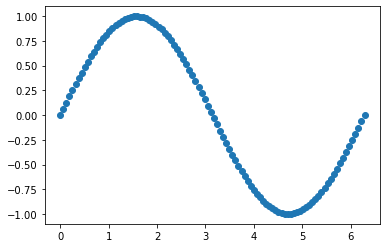

In [4]:
plt.scatter(x, y)

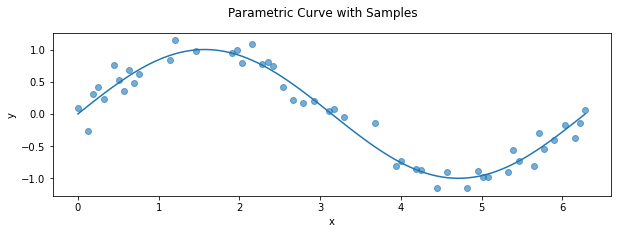

In [5]:
_ = plot((X, X_train), (y.ravel(), y_train_noisy), typ='data', title="Parametric Curve with Samples")

In [6]:
ntk_1 = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=100, c=2, bias=1e-9, 
        bias_bounds=(1e-9, 1e2))
)

ntk_2 = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    NTK(depth=100, c=2, bias=1e-9, 
        bias_bounds=(1e-9, 1e2)) +
    WhiteKernel(noise_level=0.15**2, noise_level_bounds='fixed')#(1e-9, 1))
)

lpk_1 = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    Matern(length_scale=1,
        length_scale_bounds='fixed',#(1e-9, 1e3), 
        nu=1/2)
)

lpk_2 = (
    ConstantKernel(constant_value=1.0, constant_value_bounds=(1e-9, 1e5)) * 
    Matern(length_scale=1,
        length_scale_bounds='fixed',#(1e-9, 1e3), 
        nu=1/2) +
    WhiteKernel(noise_level=0.15**2, noise_level_bounds='fixed')#(1e-9, 1e5))
)

gp_ntk_1 = GPR(kernel=ntk_1, normalize_y=True, alpha=1e-5, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_1.fit(X_train, y_train_noisy)
mean_ntk_1 = gp_ntk_1.predict(X)

gp_ntk_2 = GPR(kernel=ntk_2, normalize_y=True, alpha=1e-5, n_restarts_optimizer=9, random_state=3480795)
gp_ntk_2.fit(X_train, y_train_noisy)
mean_ntk_2 = gp_ntk_2.predict(X)

gp_lpk_1 = GPR(kernel=lpk_1, normalize_y=True, alpha=1e-5, n_restarts_optimizer=9, random_state=3480795)
ell_lpk = optimize.minimize_scalar(g, args=(gp_lpk_1, data, y-mean_ntk_1), method='bounded', bounds=[0.0001, 1000], options={'maxiter': 10000})
gp_lpk_1.set_params(**{'kernel__k2__length_scale': ell_lpk.x})
gp_lpk_1.fit(X_train, y_train_noisy)
mean_lpk_1 = gp_lpk_1.predict(X)

gp_lpk_2 = GPR(kernel=lpk_2, normalize_y=True, alpha=1e-5, n_restarts_optimizer=9, random_state=3480795)
ell_lpk = optimize.minimize_scalar(g, args=(gp_lpk_2, data, y-mean_ntk_2), method='bounded', bounds=[0.0001, 1000], options={'maxiter': 10000})
gp_lpk_2.set_params(**{'kernel__k1__k2__length_scale': ell_lpk.x})
gp_lpk_2.fit(X_train, y_train_noisy)
mean_lpk_2 = gp_lpk_2.predict(X)

print(gp_ntk_1.kernel_, gp_ntk_2.kernel_, gp_lpk_1.kernel_, gp_lpk_2.kernel_, sep='\n')

/anaconda/envs/thesis/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__bias is close to the specified upper bound 1e+02. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0.118**2 * NTK(depth=100, c=2.000, bias=0.000)
0.247**2 * NTK(depth=100, c=2.000, bias=100.000) + WhiteKernel(noise_level=0.0225)
1**2 * Matern(length_scale=0.00104, nu=0.5)
0.989**2 * Matern(length_scale=0.00237, nu=0.5) + WhiteKernel(noise_level=0.0225)


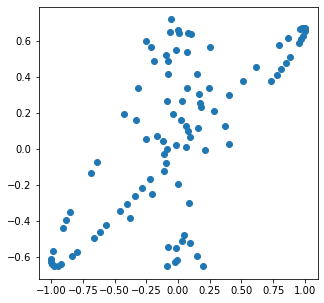

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(y-mean_lpk_1, y-mean_ntk_1)

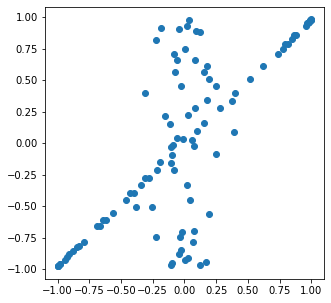

In [9]:
plt.figure(figsize=(5,5))
plt.scatter(y-mean_lpk_2, y-mean_ntk_2)

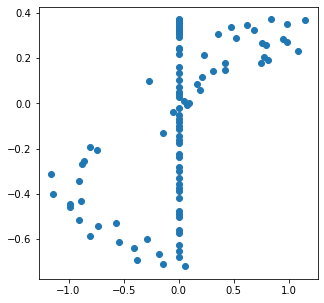

In [10]:
plt.figure(figsize=(5,5))
plt.scatter(mean_lpk_1, mean_ntk_1)

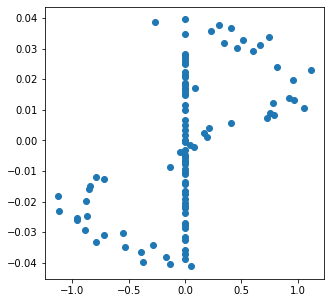

In [11]:
plt.figure(figsize=(5,5))
plt.scatter(mean_lpk_2, mean_ntk_2)

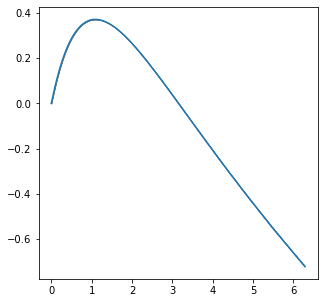

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
test_X = np.linspace(0, 2*np.pi, 1000).reshape(-1,1)
m, s = gp_ntk_1.predict(test_X, return_cov=True)
ax.plot(test_X, m)
ax.fill_between(
        test_X.ravel(),
        (m.ravel() - s[0]).ravel(),
        (m.ravel() + s[0]).ravel(),
        alpha=0.5,
        color="black",
        label=r"$\pm$ 1 std. dev.",
    )
# samples_ntk = gp_ntk_1.sample_y(np.linspace(0,1, 100).reshape(-1,1), 3)
# for i, prior in enumerate(samples_ntk.T):
#     ax.plot(np.linspace(0,1, 100).reshape(-1,1), prior.T, linestyle="--", alpha=0.5, label=f"Sampled function #{i + 1}")

# fig.legend()

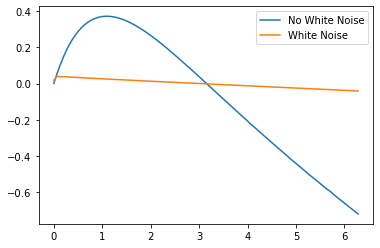

In [13]:
plt.plot(X, mean_ntk_1, label='No White Noise')
plt.plot(X, mean_ntk_2, label='White Noise')
plt.legend()

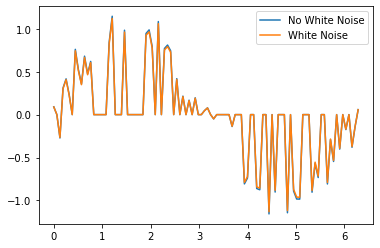

In [14]:
plt.plot(X, mean_lpk_1, label='No White Noise')
plt.plot(X, mean_lpk_2, label='White Noise')
plt.legend()